In [1]:
import os
import torch
from typing import List
import nnts
import nnts.data
from nnts import utils
import nnts.torch.preprocessing
import nnts.torch.models
import trainers as project_trainers
import nnts.metrics
import nnts.torch.datasets
import nnts.loggers
import nnts
import nnts.datasets
import features
import nnts.torch.utils
import deepar

import torch.nn.functional as F

torch.set_printoptions(precision=8, sci_mode=False)
%load_ext autoreload
%autoreload 2

In [2]:
data_path = "data"
model_name = "bettter-deepar"
dataset_name = "tourism_monthly"
results_path = "ablation-results"

df_orig, metadata = nnts.datasets.load_dataset(dataset_name)
PATH = os.path.join(results_path, model_name, metadata.dataset)

params = utils.Hyperparams(
    optimizer=torch.optim.Adam,
    loss_fn=F.smooth_l1_loss,
    batches_per_epoch=50,
    batch_size=32,
    training_method=utils.TrainingMethod.TEACHER_FORCING,
)

utils.makedirs_if_not_exists(PATH)

In [3]:
df_org = features.create_time_features(df_orig)

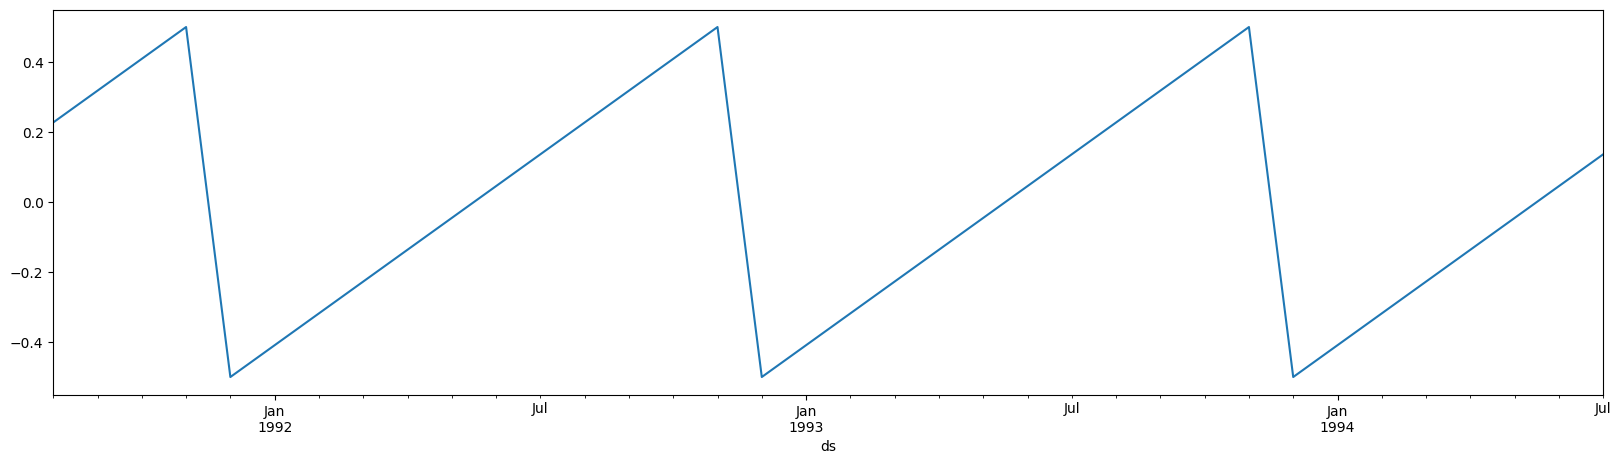

In [4]:
ax = df_orig[df_orig['unique_id'] == 'T1'].set_index('ds').tail(36)['month'].plot(figsize=(20, 5))
fig = ax.get_figure()

In [5]:
import nnts.lags
lag_seq = nnts.lags.get_lags_for_frequency(metadata.freq)
lag_seq = [lag - 1 for lag in lag_seq if lag > 1]

In [6]:
scaled_covariates = ["month", "unix_timestamp", nnts.torch.models.deepar.FEAT_SCALE]
scaled_covariate_selection_matrix = [
    [0,0,1],
    [0,1,0],
    [0,1,1],
    [1,0,0],
    [1,0,1],
    [1,1,0],
    [1,1,1],
]

In [7]:
scenario_list: List[features.LagScenario] = []

for seed in [42, 43, 44, 45, 46]:
    for row in scaled_covariate_selection_matrix:
        selected_combination = [
            covariate
            for covariate, select in zip(scaled_covariates, row)
            if select == 1
        ]
        scenario_list.append(
            features.LagScenario(
                metadata.prediction_length,
                conts=[cov for cov in selected_combination if cov != nnts.torch.models.deepar.FEAT_SCALE],
                scaled_covariates=selected_combination,
                lag_seq=lag_seq,
                seed=seed,
                dataset=metadata.dataset,
            )
        )

In [8]:
# Add the baseline scenarios
scenario_list: List[features.LagScenario] = []
for seed in [42, 43, 44, 45, 46]:
    scenario = features.LagScenario(
        metadata.prediction_length,
        conts=[],
        scaled_covariates=[],
        lag_seq=lag_seq,
        seed=seed,
        dataset=metadata.dataset,
    )
    scenario_list.append(scenario)

In [9]:
for scenario in scenario_list:
    nnts.torch.utils.seed_everything(scenario.seed)
    df = df_orig.copy()
    context_length = metadata.context_length + max(scenario.lag_seq)
    dataset_options = {
        "context_length": metadata.context_length,
        "prediction_length": metadata.prediction_length,
        "conts": scenario.conts,
        "lag_seq": scenario.lag_seq,
    }
    trn_dl, test_dl = nnts.torch.utils.create_dataloaders(
        df,
        nnts.datasets.split_test_train_last_horizon,
        context_length,
        metadata.prediction_length,
        Dataset=nnts.torch.datasets.TimeseriesDataset,
        dataset_options=dataset_options,
        Sampler=nnts.torch.datasets.TimeSeriesSampler,
    )
    logger = nnts.loggers.LocalFileRun(
        project=f"{model_name}-{metadata.dataset}",
        name=scenario.name,
        config={
            **params.__dict__,
            **metadata.__dict__,
            **scenario.__dict__,
        },
        path=PATH,
    )
    net = deepar.DeepARPoint(
        nnts.torch.models.LinearModel,
        params,
        nnts.torch.preprocessing.masked_mean_abs_scaling,
        1,
        lag_seq=lag_seq,
        scaled_features=scenario.scaled_covariates,
    )
    trner = project_trainers.TorchEpochTrainer(
        nnts.trainers.TrainerState(),
        net,
        params,
        metadata,
        os.path.join(PATH, f"{scenario.name}.pt"),
    )
    logger.configure(trner.events)

    evaluator = trner.train(trn_dl)
    y_hat, y = evaluator.evaluate(
        test_dl, scenario.prediction_length, metadata.context_length
    )
    test_metrics = nnts.metrics.calc_metrics(
        y, y_hat, nnts.metrics.calculate_seasonal_error(trn_dl, metadata.seasonality)
    )
    logger.log(test_metrics)
    print(test_metrics)
    logger.finish()

DeepARPoint(
  (decoder): UnrolledLSTMDecoder(
    (rnn): LSTM(16, 40, num_layers=2, batch_first=True, dropout=0.1)
  )
  (distribution): LinearModel(
    (main): Sequential(
      (0): Linear(in_features=40, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=1, bias=True)
    )
  )
)
Artifact saved to ablation-results/bettter-deepar/tourism_monthly/cov--lags-15-ds-tourism_monthly-seed-42.pt
Epoch 1 Train Loss: 9611.43359375
Artifact saved to ablation-results/bettter-deepar/tourism_monthly/cov--lags-15-ds-tourism_monthly-seed-42.pt
Epoch 2 Train Loss: 8061.7880859375
Artifact saved to ablation-results/bettter-deepar/tourism_monthly/cov--lags-15-ds-tourism_monthly-seed-42.pt
Epoch 3 Train Loss: 4083.0576171875
Artifact saved to ablation-results/bettter-deepar/tourism_monthly/cov--lags-15-ds-tourism_monthly-seed-42.pt
Epoch 4 Train Loss: 3452.469970703125
Artifact saved to ablation-results/bettter-deepar/tourism_monthly/cov--lags-15-ds-tourism_mo

In [ ]:
csv_aggregator = nnts.utils.CSVFileAggregator(PATH, "results")
results = csv_aggregator()

In [ ]:
results = pd.read_csv(f"{PATH}/results.csv")
results